# 2 Kernel Density Estimation
# 2.2 Task 1

In [92]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from hmmlearn import hmm
from tqdm.notebook import tqdm
from scipy.spatial.distance import cdist
import ast

### Image List
- 29
- 68
- 145
- 201
- 232

In [93]:
DATASET_PATH = './Dataset/SMAI - AQ2/CSV/'
IMAGE_PATH = './Dataset/SMAI - AQ2/images/'

df = pd.read_csv(DATASET_PATH+"TLBR_29.csv")
# img = plt.imread(IMAGE_PATH + "29.jpg")
# plt.figure(figsize=(12, 20))

# plt.imshow(img)


In [94]:
def visualize_bboxes(img, df, show = False):
    img_2 = img.copy()
    for index, rows in tqdm(df.iterrows()):
        top_left = (int(rows['Top-Left'].split(',')[0][1:]),int(rows['Top-Left'].split(',')[1][:-1]))
        bottom_right = (int(rows['Bottom-Right'].split(',')[0][1:]),int(rows['Bottom-Right'].split(',')[1][:-1]))
        cv2.rectangle(img_2, top_left, bottom_right, (255, 0, 0), 2)

    if show:
        plt.figure(figsize=(12, 20))
        plt.imshow(img_2)
        
    return img_2

# img_boxes = visualize_bboxes(img, df, show=True)


In [95]:
class KDE:
    def __init__(self, kernel='gaussian'):
        self.kernel_dict = {
            'gaussian': self._gaussian_kernel,
            'box': self._box_kernel,
            'triangular': self._triangular_kernel
        }
        self.kernel = self.kernel_dict[kernel]
        self.data = None
        self.bandwidth = None

    def fit(self, data):
        self.data = np.atleast_2d(data)

    def _gaussian_kernel(self, x):
        return (1/np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)

    def _box_kernel(self, x):
        return np.where(np.abs(x) <= 1, 0.5, 0)

    def _triangular_kernel(self, x):
        return np.where(np.abs(x) <= 1, 1 - np.abs(x), 0)


    def select_bandwidth(self, bandwidth_range):
        best_bandwidth = None
        max_likelihood = -np.inf

        for bandwidth in bandwidth_range:
            likelihood = 0
            for i in range(self.data.shape[0]):
                x_i = np.delete(self.data, i, axis=0)
                density = self._lood(self.data[i], x_i, bandwidth)
                likelihood += np.log(density)

            if likelihood > max_likelihood:
                max_likelihood = likelihood
                best_bandwidth = bandwidth

        self.bandwidth = best_bandwidth

    def _lood(self, x, data, bandwidth):
        distances = cdist(data, [x]) / bandwidth
        kernel_values = self.kernel(distances).sum(axis=0)
        density = kernel_values / (len(data) * bandwidth)
        return density

    def evaluate_density(self, x):
        x = np.atleast_2d(x)
        # print(x.shape)
        distances = cdist(self.data, x) / self.bandwidth
        kernel_values = self.kernel(distances)
        density = kernel_values.sum(axis=0) / (len(self.data) * self.bandwidth)
        return density

    def visualize(self, x_range=None, num_points=100, title=None):
        if self.data.shape[1] != 1:
            print("Data is of higher dimension, can't plot it")
            
        if x_range is None:
            x_range = (self.data.min(), self.data.max())
        x = np.linspace(x_range[0], x_range[1], num_points)
        density = self.evaluate_density(x[:, None])
        plt.plot(x, density, label='KDE')
        plt.title(f'Kernel Density Estimation: {title}')
        plt.xlabel('Data')
        plt.ylabel('Density')

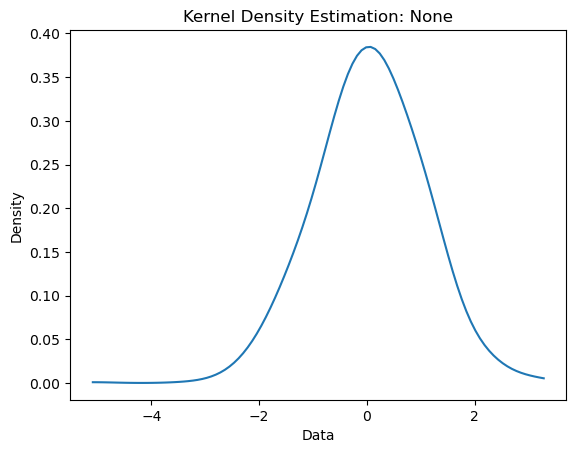

In [96]:
kde = KDE(kernel='gaussian')
data = np.random.normal(size=(1000, 1)) 
kde.fit(data)

bandwidth_range = np.linspace(0.1, 1.0, 100) 
kde.select_bandwidth(bandwidth_range)

kde.visualize()

In [97]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist


def calculate_center(row):
    (x1, y1) = map(int, row['Top-Left'][1:-1].split(','))
    (x2, y2) = map(int, row['Bottom-Right'][1:-1].split(','))

    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2
    
    return (center_x, center_y)



def calculate_hor_ver_dist(df: pd.DataFrame, n_neighbours: int = 5):
    ver_dists = []
    hor_dists = []
    
    df['Center'] = df.apply(calculate_center, axis=1)

    centers = np.array(df['Center'].tolist())
    top_lefts = np.array([tuple(map(int, tl[1:-1].split(','))) for tl in df['Top-Left']])
    bottom_rights = np.array([tuple(map(int, br[1:-1].split(','))) for br in df['Bottom-Right']])

    for idx, (center, top_left, bottom_right) in enumerate(zip(centers, top_lefts, bottom_rights)):
        left, top = top_left
        right, bottom = bottom_right

        distances = cdist(np.array([center]), centers, metric='euclidean')[0]
        closest_bboxes = np.argsort(distances)[1:n_neighbours + 1]

        for i in closest_bboxes:
            othertop_left = top_lefts[i]
            otherbottom_right = bottom_rights[i]

            otherleft, othertop = othertop_left
            otherright, otherbottom = otherbottom_right

            ver_dist = min(abs(othertop - bottom), abs(othertop - top), abs(otherbottom - bottom), abs(otherbottom - top))
            hor_dist = min(abs(otherright - left), abs(otherright - right), abs(otherleft - left), abs(otherleft - right))

            ver_dists.append(ver_dist)
            hor_dists.append(hor_dist)

    return np.array(hor_dists), np.array(ver_dists)

# Example usage:
# hor_dists, ver_dists = calculate_hor_ver_dist(df, n_neighbours=5)

In [98]:
def plot(data, title, bandwidth_range=np.linspace(1, 50, 100)):
    kde = KDE(kernel='gaussian')
    kde.fit(data)
    kde.select_bandwidth(bandwidth_range)
    kde.visualize(title=title)

In [99]:
def visualize_results(df, img, ver_threshold, hor_threshold, bandwidth_range=np.linspace(1, 50, 100)):
    hor_distances, ver_distances = calculate_hor_ver_dist(df, n_neighbours=5)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1,2,1)
    plot(np.array(hor_distances).reshape(-1,1), title='Horizontal distance', bandwidth_range=bandwidth_range)
    plt.subplot(1,2,2)
    plot(np.array(ver_distances).reshape(-1,1), title='Vertical distance', bandwidth_range=bandwidth_range)
    plt.show()  

File: 29


0it [00:00, ?it/s]

Experimenting with different bandwidth values


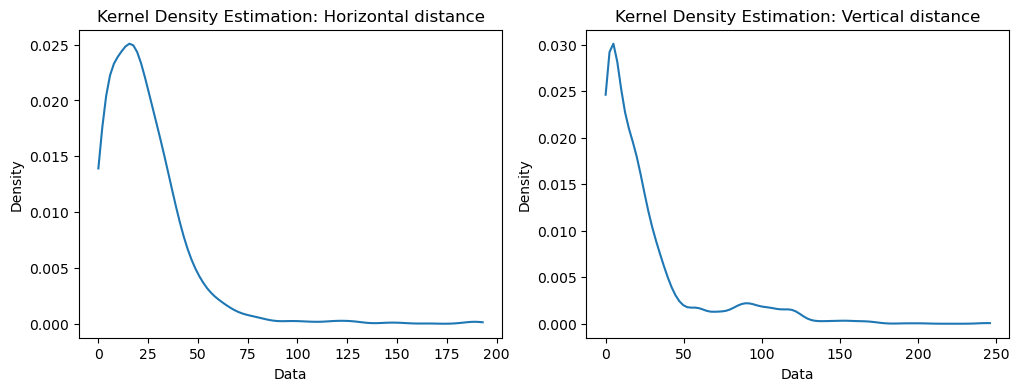

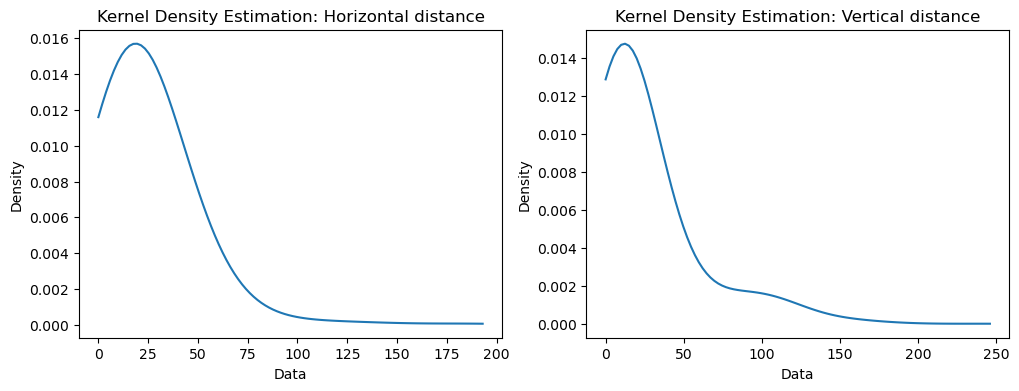

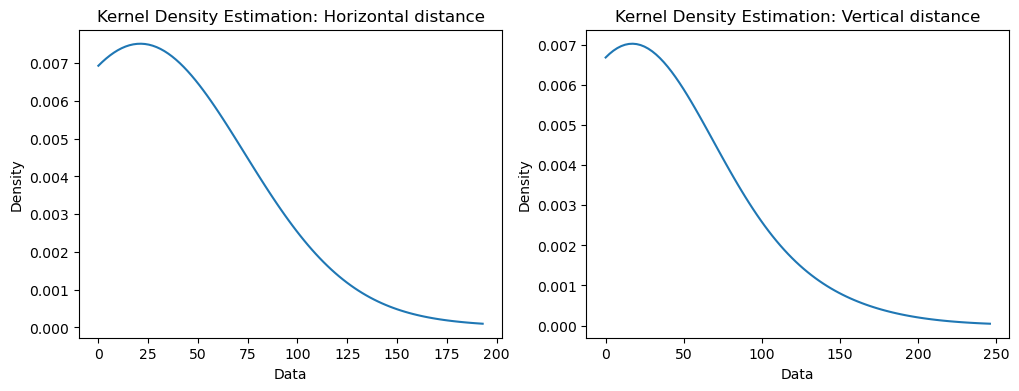

File: 68


0it [00:00, ?it/s]

Experimenting with different bandwidth values


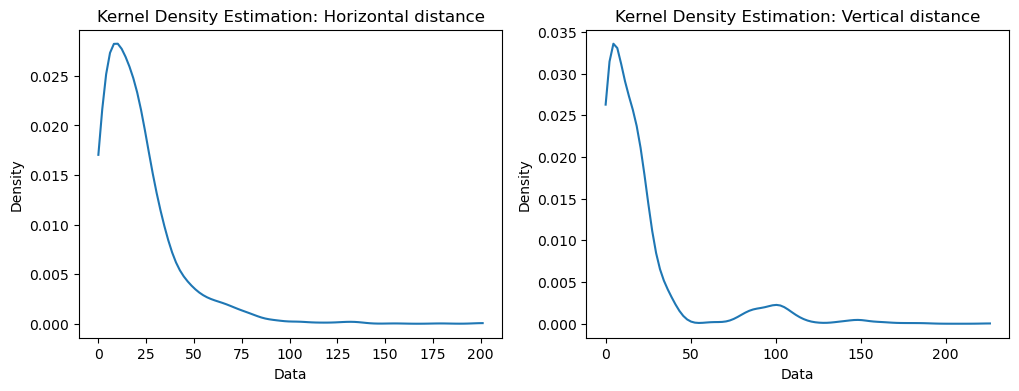

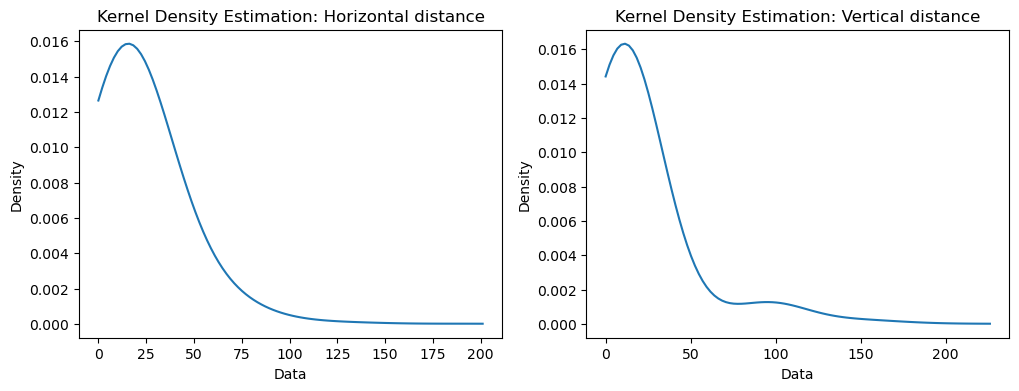

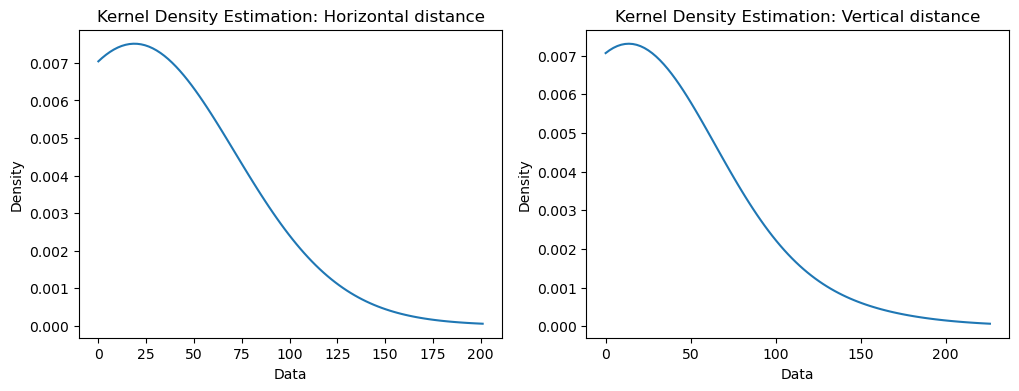

File: 145


0it [00:00, ?it/s]

Experimenting with different bandwidth values


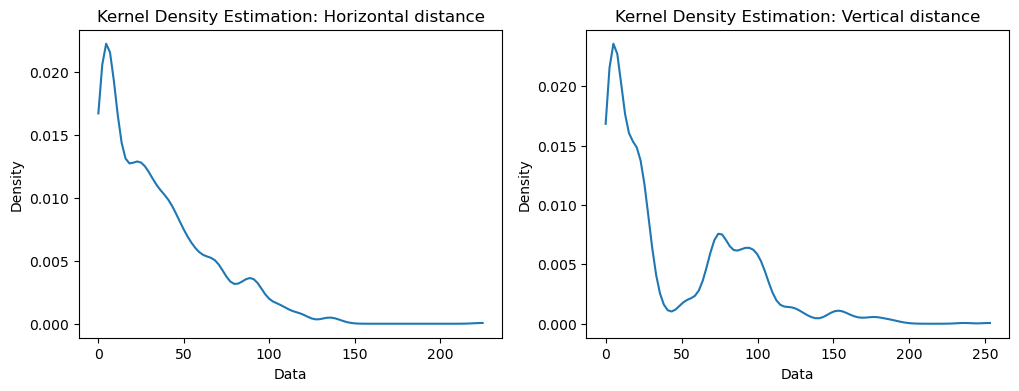

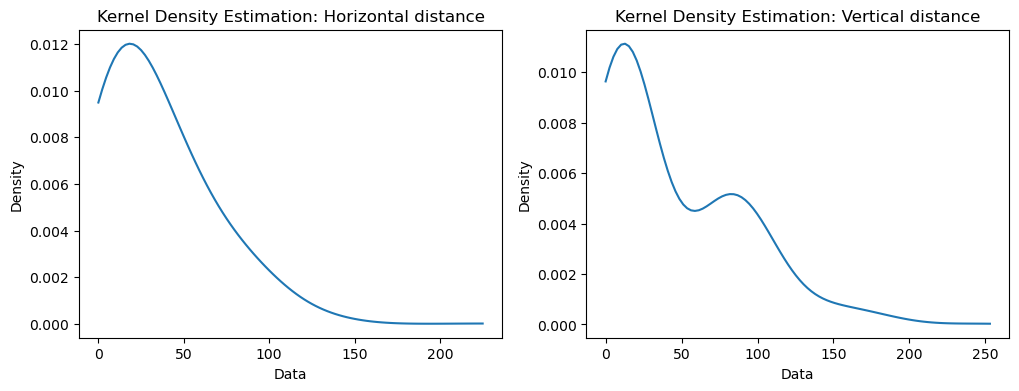

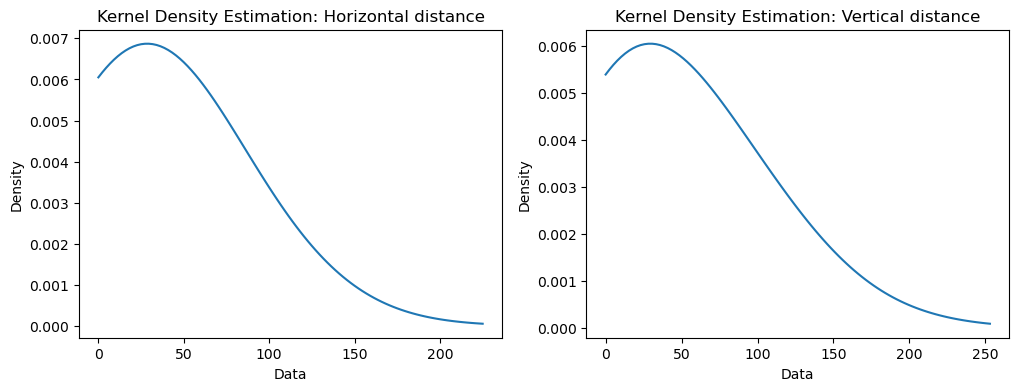

File: 232


0it [00:00, ?it/s]

Experimenting with different bandwidth values


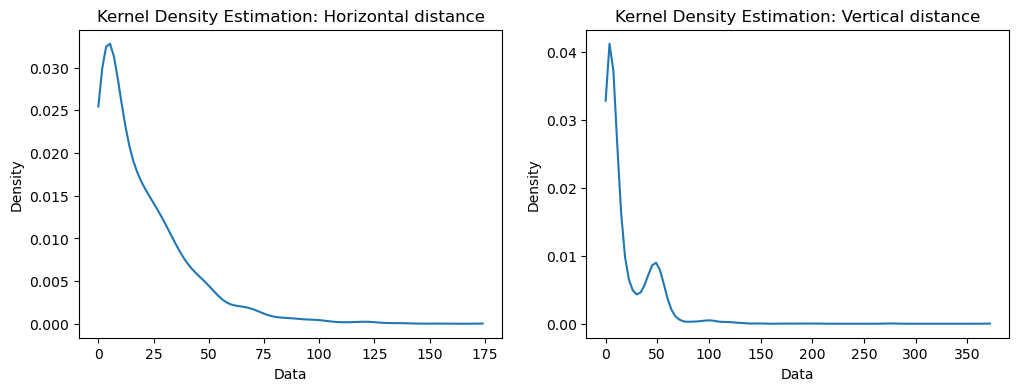

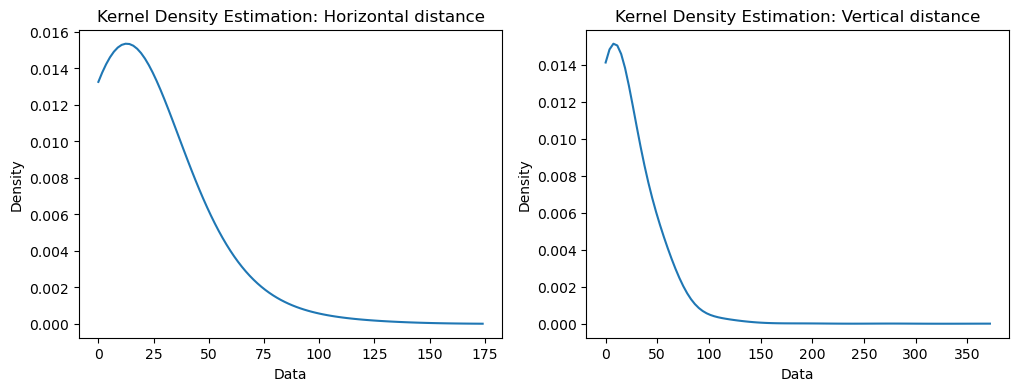

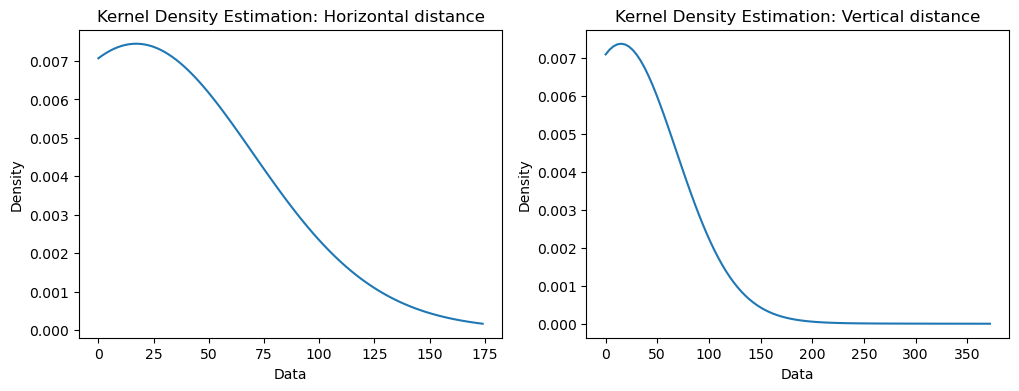

In [100]:
ver_tresholds_results = [50, 60, 50, 100]
hor_tresholds_results = [75, 75, 50, 60]

for i, idx in enumerate(['29', '68', '145', '232']):
    print(f"File: {idx}")
    df = pd.read_csv(DATASET_PATH+f'TLBR_{idx}.csv')
    img = plt.imread(IMAGE_PATH+f'{idx}.jpg')
    img_boxes = visualize_bboxes(img, df, show=False)
    # df['Top-Left'] = df['Top-Left'].apply(ast.literal_eval)
    # df['Bottom-Right'] = df['Bottom-Right'].apply(ast.literal_eval)
    
    print("Experimenting with different bandwidth values")
    for band in [5, 20, 50]:
        visualize_results(df, img, ver_threshold=ver_tresholds_results[i], hor_threshold=hor_tresholds_results[i], bandwidth_range=[band])
        
    print("="*50)